# Choose ambiguous sketches

This notebook is for choosing sketches drawn by recursive neural networks trained across stimulus categories from [Google's "Quick, Draw!" dataset](https://quickdraw.withgoogle.com/data)


These stimuli were used as stimuli for my dissertation project in Dartmouth College's Department of Psychological and Brain Sciences

Dependencies: [Tensorflow](https://www.tensorflow.org/install) and [Magenta](https://github.com/tensorflow/magenta). 
Also probably a good idea to run this notebook in the choose-stimuli conda environment (.yml file included in this repo)

In [1]:
import sys
import os
import glob
import json
import numpy as np
import pandas as pd
import warnings
sketch_morph_path = os.getcwd()

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf

from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.path import Path
from matplotlib import rc

from itertools import product
from six.moves import map, zip

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

# set numpy output to something sensible
np.set_printoptions(precision=8, 
                    edgeitems=6, 
                    linewidth=200, 
                    suppress=True)

# For inine display of animation
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

from magenta.models.sketch_rnn.utils import *
from PIL import Image
my_dpi = 192 # found here: https://www.infobyip.com/detectmonitordpi.php

import random
from itertools import permutations

/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dty

In [2]:
# define some classes and functions for making stimuli
class SketchPath(Path):
    
    def __init__(self, data, factor=.2, *args, **kwargs):
        
        vertices = np.cumsum(data[::, :-1], axis=0) / factor
        codes = np.roll(self.to_code(data[::,-1].astype(int)), 
                        shift=1)
        codes[0] = Path.MOVETO

        super(SketchPath, self).__init__(vertices, 
                                         codes, 
                                         *args, 
                                         **kwargs)
        
    @staticmethod
    def to_code(cmd):
        # if cmd == 0, the code is LINETO
        # if cmd == 1, the code is MOVETO (which is LINETO - 1)
        return Path.LINETO - cmd
    
    
def draw(sketch_data, factor=.2, pad=(10, 10), ax=None):

    if ax is None:
        ax = plt.gca()

    x_pad, y_pad = pad
    
    x_pad //= 2
    y_pad //= 2
        
    x_min, x_max, y_min, y_max = get_bounds(data=sketch_data,
                                            factor=factor)
    
    ax.set_xlim(x_min-x_pad, x_max+x_pad)
    ax.set_ylim(y_max+y_pad, y_min-y_pad)

    sketch = SketchPath(sketch_data)

    patch = patches.PathPatch(sketch, facecolor=(1.,1.,1.,0.))
    ax.add_patch(patch)

    return

The following assumes that you have run the generate_candidates_ambiguous.py script to generate sketches from the RNNS trained over object categories (e.g. pig_alarm-clock; these models are included in the hyper/models/ directory). 

After generating the candidates, run ink_totals_ambiguous.py to find the amount of black "ink" in each sketch.

In [5]:
# get the sketches for each category
sketch_dict = {}
dict_pix = {}
categories = []
pixel_counts = []
for file in glob.glob(os.path.join(sketch_morph_path, 'stimuli','candidates_ambiguous', '*.npz')):
    file_npz = np.load(file)
    category = file.split('/')[-1].split('.')[0]
    categories.append(category)
    sketch_dict[category] = file_npz['sketches']
    dict_pix[category] = file_npz['pix_count']
    pixel_counts.append(file_npz['pix_count'])
    
categories

['face_radio', 'pig_alarm-clock']

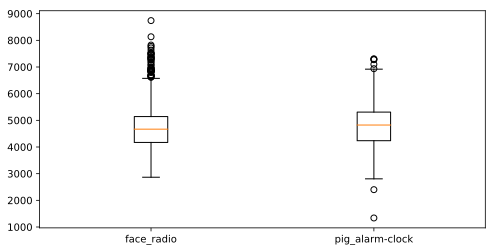

In [8]:
fig, ax = plt.subplots(figsize=(8,4));
ax.boxplot(pixel_counts, labels=categories);
plt.savefig(os.path.join(sketch_morph_path, 'ambiguous_sketch_pixel_counts.png'), format='png')


In [10]:
grand_mean = np.mean(pixel_counts)
st_dev = np.std(pixel_counts)
print('grand mean is {} | standard deviation is {}'.format(grand_mean,st_dev))

grand mean is 4731.13082745098 | standard deviation is 762.2821924344594


In [15]:
category= 'pig_alarm-clock'

sketches = sketch_dict[category]
pixels = dict_pix[category]
# draw all of the candidates
fig, ax_arr = plt.subplots(nrows=200, 
                           ncols=10, 
                           figsize=(10, 200),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
# fig.tight_layout()
im_no = 0
for ax_row in ax_arr:
    for ax in ax_row:
        draw(sketches[im_no], ax=ax)
        ax.set_xlabel(round(pixels[im_no],2), fontsize=8)
        if im_no%10 ==0:
            ax.set_ylabel(im_no)
        im_no += 1

plt.show()

Choose which sketches to save for each ambiguous category (I chose 8 each for the experiment)
My choices are already included in the repo, but going through each of the categories here will overwrite them

In [16]:
#initialize these as empty lists
sketches_to_save = []
pixel_counts_to_save = []

#index of chosen sketches here
good = [610,1200,1294,1334,1350,1505,1760,1877]

for sketch in good:
    sketches_to_save.append(sketch_dict[category][sketch])
    pixel_counts_to_save.append(dict_pix[category][sketch])
    
np.savez(os.path.join(sketch_morph_path, 'stimuli','sketches','ambiguous',category+'.npz'), 
         sketches=sketches_to_save)
np.savez(os.path.join(sketch_morph_path, 'stimuli','sketches','ambiguous',category+'_pixelcounts.npz'),
         counts=pixel_counts_to_save)

Plot the chosen sketches along with the amount of black "ink" for each

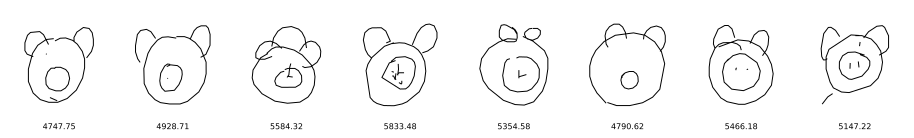

In [17]:
fig, ax_arr = plt.subplots(nrows=1, 
                           ncols=len(sketches_to_save), 
                           figsize=(2*len(sketches_to_save), 2),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
# fig.tight_layout()
im_no = 0
for ax in ax_arr:
    draw(sketches_to_save[im_no], ax=ax)
    ax.set_xlabel(round(pixel_counts_to_save[im_no],2), fontsize=8)
    im_no += 1

plt.show()

Next, we adjust the size of each sketch so that they have  the same amount of 'ink'

In [18]:
chosen_sketch_dict = {}

for file in glob.glob(os.path.join(sketch_morph_path, 'stimuli','sketches','ambiguous', '*.npz')):
    if 'pixelcounts' not in file:
        chosen_sketch_dict[file.split('/')[-1].split('.')[0]] = np.load(file)['sketches']

In [19]:
chosen_sketch_dict.keys()

dict_keys(['face_radio', 'pig_alarm-clock'])

Get ink total on white background

In [20]:
ink_totals = []
chosen_pix_dict = {}
for category in chosen_sketch_dict:
    print('doing category {}'.format(category))
    chosen_pix_dict[category]=[]
    for k, sketch in enumerate(chosen_sketch_dict[category]):
        fig, ax = plt.subplots(nrows=1,ncols=1,
                               figsize=(600/my_dpi,600/my_dpi))

        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

        draw(sketch, ax=ax)
        #         plt.axis('off')
        plt.savefig(os.path.join(sketch_morph_path, 'stimuli',
                                 'sketches','temp',
                                 category+'_temp.png'),dpi=my_dpi)        
        im = Image.open(os.path.join(sketch_morph_path, 'stimuli',
                                     'sketches','temp',
                                     category+'_temp.png')).convert('L');
        im_array = np.array(im)
        ink_total = sum(sum(1 - im_array/255))
        ink_totals.append(ink_total)
        chosen_pix_dict[category].append(ink_total)
        im.close()
    plt.close('all')

doing category face_radio
doing category pig_alarm-clock


In [21]:
for category in chosen_pix_dict:
    print(category)
    print(chosen_pix_dict[category])

face_radio
[9223.098039215643, 8891.66274509804, 9284.847058823538, 8670.878431372534, 8608.043137254932, 10298.345098039204, 9949.047058823511, 9166.066666666644]
pig_alarm-clock
[8708.592156862753, 8939.486274509803, 9796.1294117647, 10113.298039215673, 9508.305882352917, 8777.423529411786, 9651.039215686269, 9232.415686274479]


In [22]:
print('mean is {:.2f}'.format(np.mean(ink_totals)))
print('standard deviation is {:.2f}'.format(np.std(ink_totals)))
print('range is {:.2f} to {:.2f}'.format(np.min(ink_totals),np.max(ink_totals)))

mean is 9301.17
standard deviation is 519.31
range is 8608.04 to 10298.35


Match amount of black 'ink' for all sketches on white background (within 50 black pixels worth of 'ink')

In [23]:
chosen_sizes = {}
for category in chosen_sketch_dict:
    chosen_sizes[category] = []

    for k,sketch in enumerate(chosen_sketch_dict[category]):
        cycle_count = 1
        ink_total = chosen_pix_dict[category][k]
        size = 600
        while abs(ink_total-np.mean(ink_totals)) > 50:
            cycle_count += 1
            fig, ax = plt.subplots(nrows=1,ncols=1,
                                   figsize=(size/my_dpi,size/my_dpi))
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
            draw(sketch, ax=ax)
            plt.savefig(os.path.join(sketch_morph_path, 'stimuli',
                                     'sketches','temp',
                                     category+'_temp.png'),dpi=my_dpi)

            im = Image.open(os.path.join(sketch_morph_path, 'stimuli',
                                         'sketches','temp',
                                         category+'_temp.png')).convert('L');
            im_array = np.array(im)
            ink_total = sum(sum(1 - im_array/255))

            diff = abs(ink_total-np.mean(ink_totals))
            
            if ink_total > np.mean(ink_totals):
                size = size - np.random.rand()*10
            elif ink_total < np.mean(ink_totals):
                size = size + np.random.rand()*10
            
            plt.close('all')

            if cycle_count%20 == 0:
                print('diff is {}, resetting size to {}'.format(abs(ink_total-np.mean(ink_totals)),size))
                        
        print('finished {} sketch {}. Size is {}'.format(category,k, size))
        chosen_sizes[category].append(size)


diff is 1172.6066176470931, resetting size to 610.0317702582217
finished face_radio sketch 0. Size is 608.7110586868514
finished face_radio sketch 1. Size is 620.433832033443
finished face_radio sketch 2. Size is 600
finished face_radio sketch 3. Size is 642.6180481445325
finished face_radio sketch 4. Size is 639.3983893617753
diff is 508.68112745096914, resetting size to 583.8175973529624
diff is 875.641911764691, resetting size to 557.7672451289678
finished face_radio sketch 5. Size is 547.0638243225671
diff is 423.12426470589344, resetting size to 614.0698085507287
diff is 1216.17769607841, resetting size to 624.9105138985462
finished face_radio sketch 6. Size is 627.9975452369841
diff is 1031.877205882367, resetting size to 624.8359650892567
diff is 828.1830882353097, resetting size to 639.9285974426084
finished face_radio sketch 7. Size is 697.1844727342135
finished pig_alarm-clock sketch 0. Size is 633.1991327238087
finished pig_alarm-clock sketch 1. Size is 623.9852340066618
dif

In [25]:
for category in chosen_sizes:
    print(category)
    print(chosen_sizes[category])

face_radio
[608.7110586868514, 620.433832033443, 600, 642.6180481445325, 639.3983893617753, 547.0638243225671, 627.9975452369841, 697.1844727342135]
pig_alarm-clock
[633.1991327238087, 623.9852340066618, 651.3414750489923, 546.1690702007892, 591.5440489292203, 629.87634962447, 574.0313459283202, 597.9673792808728]


Get amount of 'ink' for resized sketches drawn on a gray background, 
accounting for the change in image size (extra_pix)

In [26]:
ink_totals_graybg = [] 
for category in chosen_sizes:
    for k, sketch in enumerate(chosen_sketch_dict[category]):
        size = chosen_sizes[category][k]
        extra_pix = size**2 - 600**2 # negative for sketches smaller than 600x600
        fig, ax = plt.subplots(nrows=1,ncols=1,
                               figsize=(size/my_dpi,size/my_dpi))
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        ax.set_facecolor((.5,.5,.5))
        fig.set_facecolor((.5,.5,.5))
        for spine in ax.spines.values():
            spine.set_edgecolor((.5,.5,.5))
        draw(sketch, ax=ax)
        plt.savefig(os.path.join(sketch_morph_path, 'stimuli',
                                 'sketches','temp',
                                 category+'_temp_gray.png'),dpi=my_dpi)

        im = Image.open(os.path.join(sketch_morph_path, 'stimuli',
                                     'sketches','temp',
                                     category+'_temp_gray.png')).convert('L');
        im_array = np.array(im)
        ink_total_graybg = sum(sum(1-im_array/255)) - (extra_pix*128)/255
        ink_totals_graybg.append(ink_total_graybg)
        
        im.save(os.path.join(sketch_morph_path,'stimuli','sketches','gray_bg',category+'_'+str(k)+'.png'), 
                format='png')

        plt.close('all')


now find stats for the resized black sketches on gray backgrounds

In [27]:
print('mean is {:.2f}'.format(np.mean(ink_totals_graybg)))
print('standard deviation is {:.2f}'.format(np.std(ink_totals_graybg)))
print('range is {:.2f} to {:.2f}'.format(np.min(ink_totals_graybg),np.max(ink_totals_graybg)))

mean is 182399.80
standard deviation is 356.66
range is 181893.38 to 183051.07


Next, we will make movies from all of the chosen sketches. First, 2s videos.

In [29]:
def animate_1(i, color_frames, movie_sketch):
    if i <= len(movie_sketch):
        the_sketch = SketchPath(movie_sketch[:i+1])
        the_patch  = ax.add_patch(patches.PathPatch(the_sketch,
                                  facecolor=(.5,.5,.5), edgecolor=(0.,0.,0.)))
    else:
        the_sketch = SketchPath(movie_sketch)
        the_patch  = ax.add_patch(patches.PathPatch(the_sketch,
                                  facecolor=(.5,.5,.5), edgecolor=(0.,0.,0.)))
    
    return the_patch


def make_movie_fig(movie_sketch, size):
    # create an axis to draw a single sketch
    fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(size/my_dpi, size/my_dpi),
                           subplot_kw=dict(xticks=[],
                                           yticks=[]),
                           frameon=False)


    fig.tight_layout()

    x_pad, y_pad = 10, 10

    x_pad //= 2
    y_pad //= 2

    (x_min,
     x_max,
     y_min,
     y_max) = get_bounds(data=movie_sketch, factor=.2)

    ax.set_xlim(x_min-x_pad, x_max+x_pad);
    ax.set_ylim(y_max+y_pad, y_min-y_pad);
#     ax.axis('off');
    ax.set_facecolor((.5,.5,.5)) # this sould make the background gray
    fig.set_facecolor((.5,.5,.5))
    for spine in ax.spines.values():
        spine.set_edgecolor((.5,.5,.5))
        
    return fig, ax

In [31]:
for category in chosen_sketch_dict:
    for k, sketch in enumerate(chosen_sketch_dict[category]):
        # draw the sketch at the right size
        fig, ax = make_movie_fig(sketch,chosen_sizes[category][k])
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        movie_length = 1920 # length in milliseconds
        frames = sketch.shape[0]+44 # number of frames in sketch
        interval = movie_length/(frames-1) # calculate time in between frames
        print( 'sketch category: {} \n'
               'length of movie: {}ms \n'
               'size of movie: {} \n'
               'number of frames: {} \n'
               'time between frames: {:.2f} ms'.format(category,movie_length,chosen_sizes[category][k],frames,interval))

        print('\n')

        outfile = os.path.join(sketch_morph_path,'stimuli', 'ambiguous_videos_resized', 'short', category+'_'+str(k)+'.mov')

        color_frames = np.repeat(False, frames)
        k = np.random.randint(1,frames-1)
        fargs = (color_frames,sketch)

        animation = FuncAnimation(fig,
                                  animate_1,
                                  fargs=(fargs),
                                  frames=frames,
                                  interval=interval,
                                  repeat_delay=1000*3)

        print('saving full movie ... \n')

        animation.save(outfile, codec="png",
                       dpi=my_dpi, bitrate=-1)

        plt.close('all')

sketch category: face_radio 
length of movie: 1920ms 
size of movie: 608.7110586868514 
number of frames: 106 
time between frames: 18.29 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 1920ms 
size of movie: 620.433832033443 
number of frames: 93 
time between frames: 20.87 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 1920ms 
size of movie: 600 
number of frames: 102 
time between frames: 19.01 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 1920ms 
size of movie: 642.6180481445325 
number of frames: 99 
time between frames: 19.59 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 1920ms 
size of movie: 639.3983893617753 
number of frames: 98 
time between frames: 19.79 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 1920ms 
size of movie: 547.0638243225671 
number of frames: 112 
time between frames: 17.30 ms


saving full movie ... 

sketch category:

Next, 8s videos

In [32]:
for category in chosen_sketch_dict:
    for k, sketch in enumerate(chosen_sketch_dict[category]):
        # draw the sketch at the right size
        fig, ax = make_movie_fig(sketch,chosen_sizes[category][k])
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        movie_length = 7940 # length in milliseconds
        frames = sketch.shape[0] # number of frames in sketch
        interval = movie_length/(frames-1) # calculate time in between frames
        print( 'sketch category: {} \n'
               'length of movie: {}ms \n'
               'size of movie: {} \n'
               'number of frames: {} \n'
               'time between frames: {:.2f} ms'.format(category,movie_length,chosen_sizes[category][k],frames,interval))

        print('\n')

        outfile = os.path.join(sketch_morph_path,'stimuli', 'ambiguous_videos_resized', 'long', category+'_'+str(k)+'_8s.mov')

        color_frames = np.repeat(False, frames)
        k = np.random.randint(1,frames-1)
        fargs = (color_frames,sketch)

        animation = FuncAnimation(fig,
                                  animate_1,
                                  fargs=(fargs),
                                  frames=frames,
                                  interval=interval,
                                  repeat_delay=1000*3)

        print('saving full movie ... \n')

        animation.save(outfile, codec="png",
                       dpi=my_dpi, bitrate=-1)

        plt.close('all')

sketch category: face_radio 
length of movie: 7940ms 
size of movie: 608.7110586868514 
number of frames: 62 
time between frames: 130.16 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 7940ms 
size of movie: 620.433832033443 
number of frames: 49 
time between frames: 165.42 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 7940ms 
size of movie: 600 
number of frames: 58 
time between frames: 139.30 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 7940ms 
size of movie: 642.6180481445325 
number of frames: 55 
time between frames: 147.04 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 7940ms 
size of movie: 639.3983893617753 
number of frames: 54 
time between frames: 149.81 ms


saving full movie ... 

sketch category: face_radio 
length of movie: 7940ms 
size of movie: 547.0638243225671 
number of frames: 68 
time between frames: 118.51 ms


saving full movie ... 

sketch catego

Great, now we have a set of luminance-matched, ambiguous sketches for the experiment!